In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
from myo_supportfs import *
import os
import scipy.integrate as integrate
from numba import jit
# from numba.experimental import jitclass
# from numba import int32, float32
# from typing import List

from typing import Any
from tqdm import tqdm

def plot_float_distribution(data,fig_size=(4,3),title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size[0],fig_size[1])
    x = []
    for i in range(len(data)):
        if np.isnan(data[i]):
            continue
        else:
            x.append(data[i])
    u_vs = np.unique(x)

    if len(x) == 0:
        ax.set_title(title +' is empty data')
    elif len(u_vs)==1:
        ax.set_title(title + ' all data is repeated with value: {}'.format(u_vs[0]))
    else:
        x = np.asarray(x)
        q25, q75 = np.percentile(x, [25, 75])
        bins = 0
        if q25==q75:
            bins = np.minimum(100,len(u_vs))
        else:
            bin_width = 2 * (q75 - q25) * len(x) ** (-1 / 3)
            bins = np.minimum(100, round((np.max(x) - np.min(x)) / bin_width))
        nan_rate = np.sum(np.isnan(data))/len(data)
        ax.set_title(title+'. n of unique values {}'.format(len(u_vs)))
        ax.set_xlabel('nan rate {}'.format(nan_rate))
        density,bins = np.histogram(x,bins=bins,density=True)
        unity_density = density / density.sum()
        widths = bins[:-1] - bins[1:]
        ax.bar(bins[1:], unity_density,width=widths)

    return fig,ax

@jit(nopython=True)
def Heviside(x:float) -> float:
    if x < 0.0:
        return 0.0
    return 1.0

class J_ch:
    t1:                     float
    t2:                     float
    delta_t:                float
    tau:                    float
    T:                      float
    rho:                    float
    alpha:                  float
    volume:                 float
    start_absorbtion:       float
    stop_absorbtion:        float
    mass_before_absorbtion: float
    last_J:                 float
    last_delta_J:           float
    is_mass_dont_used_up:   int

    def __init__(self, t1:float, t2:float,delta_t:float, tau:float, T:float,rho:float,alpha:float,volume:float) -> None:
        self.t1 = t1
        self.t2 = t2
        self.delta_t = delta_t
        self.tau = tau
        self.T = T
        self.rho = rho
        self.alpha = alpha
        self.volume = volume
        self.start_absorbtion = t2 + tau
        self.stop_absorbtion = t2 + tau + T 
        self.mass_before_absorbtion = (1.0/volume)*alpha*rho*(t2-t1)
        self.last_delta_J = 0.0
        self.last_J = self.mass_before_absorbtion
        self.is_mass_dont_used_up = 1
    def step(self, t: float, velocity: float) -> None:
        # if t < self.start_absorbtion or t > self.stop_absorbtion:
        #     return
        # else:
            # if self.last_J == 0.0:
            #     self.last_delta_J = 0.0
            #     return 

            # self.last_delta_J = -velocity*self.delta_t
            # if self.last_J + self.last_delta_J < 0.0:
            #     self.last_delta_J = -self.last_J
                
            # self.last_J = np.maximum(self.last_J + self.last_delta_J, 0.0)
            
            # if self.last_J == 0.0:
            #     self.is_mass_dont_used_up = 0

        if t < self.start_absorbtion or t > self.stop_absorbtion or self.last_J == 0.0:
            return
        else:
            self.last_delta_J = -velocity*self.delta_t
            self.last_J = np.maximum(self.last_J + self.last_delta_J, 0.0)
            if self.last_J == 0.0:
                self.last_delta_J = 0.0
                self.is_mass_dont_used_up = 0


    def get_J(self, t:float):
        # return self.last_J * Heviside(t - self.start_absorbtion) * Heviside(self.stop_absorbtion - t)
        return self.last_J * int(t>=self.start_absorbtion and t <= self.stop_absorbtion)
    def get_dJdt(self, t:float):
        # return self.last_delta_J/self.delta_t * Heviside(t - self.start_absorbtion) * Heviside(self.stop_absorbtion - t)
        return self.last_delta_J/self.delta_t * int(t>=self.start_absorbtion and t <= self.stop_absorbtion)
    
class J_sum:
    J_arr: List[J_ch]
    V_total: float
    def __init__(self, V_total) -> None:
        self.V_total = V_total
        self.J_arr = []
    def add_J_ch(self, t1:float, t2:float, delta_t:float, tau:float, T:float,rho:float,alpha:float, volume:float):
        J_ = J_ch(t1,t2,delta_t,tau,T,rho,alpha,volume)
        self.J_arr.append(J_)
    def get_dJdt(self,t:float)->float:
        s_ = 0.0
        for i in range(len(self.J_arr)):
            s_ += self.J_arr[i].get_dJdt(t)
        return s_
    
    def get_J(self,t:float)->float:
        s_ = 0.0
        # arr_of_values = np.zeros(shape=(len(self.J_arr),))
        for i in range(len(self.J_arr)):
            # arr_of_values[i] = self.J_arr[i].get_J(t) 
            s_ += self.J_arr[i].get_J(t)
        return s_

    def get_velocity(self, t: float) -> float:
        num_ = 0.0
        for i in range(len(self.J_arr)):
            J_ = self.J_arr[i]
            # num_ += Heviside(t - J_.start_absorbtion) * Heviside(J_.stop_absorbtion - t)*J_.is_mass_dont_used_up
            num_ += int(t>=J_.start_absorbtion and t <= J_.stop_absorbtion)*J_.is_mass_dont_used_up
        num_ = int(num_)
        if num_ == 0.0:
            return 0.0
        else:
            return self.V_total/num_
        
    def step(self,t:float):
        V = self.get_velocity(t)
        for i in range(len(self.J_arr)):
            self.J_arr[i].step(t, velocity=V)


def itegrate_func(func, time_grid):
    out_ = np.zeros(shape=(len(time_grid),))
    sum_= 0.0
    for i in range(1,len(time_grid)):
        tau_i = time_grid[i]-time_grid[i-1]
        mid_t = 0.5*(time_grid[i]+time_grid[i-1])
        mid_point = func(mid_t)
        sum_ += tau_i*mid_point
        out_[i] = sum_
    return out_
def itegrate_arr(arr_, time_grid):
    out_ = np.zeros(shape=(len(time_grid),))
    sum_= 0.0
    for i in range(1,len(time_grid)):
        tau_i = time_grid[i]-time_grid[i-1]
        right_point = arr_[i]
        sum_ += tau_i*right_point
        out_[i] = sum_
    return out_

def simple_plot_many_y(x,y_vec,title='', labels=[],fig_size = (4,4),scale= 'linear'):
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size)
    for i in range(len(y_vec)):
        y_ = y_vec[i]
        x_ = x
        if len(labels) == len(y_vec):
            ax.plot(x_,y_,label = labels[i])
        else:
            ax.plot(x_,y_)
    ax.legend()
    ax.set_title(title)
    ax.set_yscale(scale)
    ax.grid()
    return fig,ax

In [2]:
diet_table_path =r'C:\grlab\data\diet_Mikhail.xlsx'
diet_data = read_diet(diet_table_path)
F_carb_chunks,F_carb = make_Fcarb(diet_data)
F_prot_chunks,F_prot = make_Fprot(diet_data)
F_fat_chunks,F_fat  = make_Ffat(diet_data)

In [3]:

J_s_prot = J_sum(V_total=float(90/60)) # [ммоль/мин]
tau_grid = 0.1
for i in range(len(F_prot_chunks)):
    ch_ = F_prot_chunks[i]
    J_s_prot.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

t_0 = 400
t_end = 1000
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(start=t_0, stop=t_end, num=N)
J_total = np.zeros(shape=(len(time_grid),),dtype=np.float32)
J_chunks = []
delta_AA = np.zeros(shape=(len(time_grid),),dtype=np.float32)
v_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
n_vec = np.zeros(shape=(len(time_grid),),dtype=np.float32)
for i in tqdm(range(len(time_grid))):
    J_s_prot.step(time_grid[i])
    J_total_= J_s_prot.get_J(time_grid[i])
    J_total[i] = J_total_
    delta_AA[i] = - J_s_prot.get_dJdt(time_grid[i])
    # if delta_AA[i] < 1.0 and delta_AA[i] > 0.0:
    #     print(time_grid[i])
J_chunks = np.array(J_chunks)

100%|██████████| 6001/6001 [00:00<00:00, 12810.27it/s]


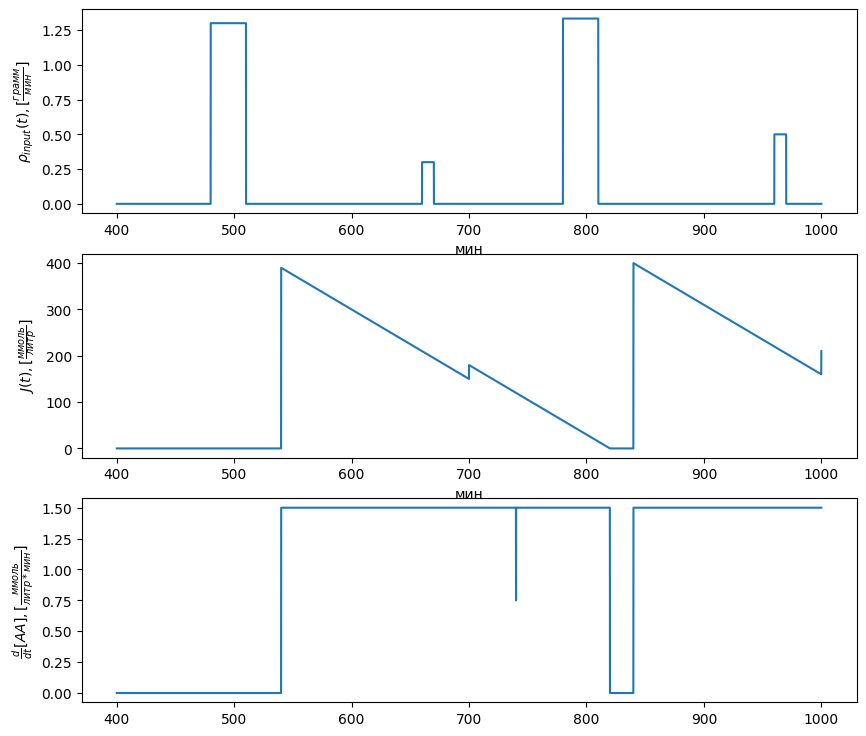

In [7]:
fig,ax = plt.subplots(nrows=3,ncols=1)
fig.set_size_inches(10,9)
ax[0].plot(time_grid,[F_prot(el) for el in time_grid])
ax[0].set_ylabel(r'$\rho_{input}(t),[\frac{грамм}{мин}]$')
ax[0].set_xlabel('мин')
# ax[1].plot(time_grid,itegrate_func(F_prot, time_grid))
# ax[1].set_ylabel(r'$AUC(\rho_{input}),[грамм]$')
# ax[1].set_xlabel('мин')
# ax[2].plot(time_grid,J_total,label= r'$J_{\Sigma}$')
# ax[2].set_ylabel(r'$J(t),[\frac{ммоль}{литр}]$')
# ax[2].set_xlabel('мин')
ax[1].plot(time_grid,J_total,label= r'$J_{\Sigma}$')
ax[1].set_ylabel(r'$J(t),[\frac{ммоль}{литр}]$')
ax[1].set_xlabel('мин')

# for i in range(len(J_chunks[0])):
#     ax[2].plot(time_grid, J_chunks[:,i])

ax[2].plot(time_grid, delta_AA)
ax[2].set_ylabel(r'$\frac{d}{dt}[AA],[\frac{ммоль}{литр*мин}]$')
# ax[4].plot(time_grid, itegrate_arr(delta_AA,time_grid))
# ax[4].set_ylabel(r'$[AA](t),[\frac{ммоль}{литр}]$')

# ax[2].legend()
# ax[0].grid(visible=True, which='both', axis='both')
# ax[1].grid(visible=True, which='both', axis='both')
# ax[2].grid(visible=True, which='both', axis='both')
# ax[3].grid(visible=True, which='both', axis='both')
# ax[4].grid(visible=True, which='both', axis='both')

# ax[0].set_ylim(bottom=0.0)
# ax[1].set_ylim(bottom=0.0)
# ax[2].set_ylim(bottom=0.0)
# ax[2].set_ylim(bottom=0.0)
# ax[3].set_ylim(bottom=0.0)
# ax[4].set_ylim(bottom=0.0)

# ax[0].set_xlim([t_0,t_end])
# ax[1].set_xlim([t_0,t_end])
# ax[2].set_xlim([t_0,t_end])
# ax[3].set_xlim([t_0,t_end])
# ax[4].set_xlim([t_0,t_end])
fig.savefig('tmp_plot.png',dpi=100)


chunk - это $i$-й прием пищи. далее нижний индекс $ch$, принадлежность этому приему пищи, опускаается  
для большинства букв с целью разгрузки записи.  
$a,b$ - начало и конец $i$-го приема пищи.  
$\Delta t$ - малый шаг интегрирования системы.  
$\tau$ - время задержки до начала абсорбции $i$-го приема пищи.  
$T$ - максимальная длительность абсорбции $i$-го приема пищи.  
$\rho$ - скорость поступления пищи. размерность $[\frac{грамм}{мин}]$.  
$V_{total}^{absorbtion}$ - скорость абсорбции для выбранного вещества. размерность $[\frac{ммоль}{литр*мин}]$.  
$V_{ch}^{absorbtion}$ - скорость абсорбции для $i$-го приема пищи. размерность $[\frac{ммоль}{литр*мин}]$.  
скорость абсорбции ограничена, поэтому я ее разделил на число кусочков пищи, абсорбирующихся в текущий момент.  
$\frac{\alpha}{V_{system}}$ - перевод единиц из $[грамм]$ в $[\frac{ммоль}{литр}]$.  
$\alpha = 9.0 [\frac{ммоль}{грамм}]$  
$V_{system}= 1.0 [литр]$  
$\tau=30 [мин]$  
$T = 480 [мин]$  


\begin{equation}
J_{ch}(t) =
    \begin{cases}
      0,t< a   \\
      \frac{\alpha}{V_{system}} \int_{a}^{t}{\rho(t^{'})dt^{'}}, t \in [a,b+\tau] \\
      \max(J_{ch}(t-\Delta t) - V_{ch}^{absorbtion}(t) \Delta t,0),t \in (b+\tau,b+\tau+T] \\
      0, t> b+\tau+T
    \end{cases}
\end{equation}  

$$
V_{ch}^{absorbtion}(t) = \frac{V_{total}^{absorbtion}}{\sum_{i=1}^{N_{chunks}(t)}{[ H(t-(b+\tau))H((b+\tau+T)-t) = 1]}}
$$

перекачка в $[AA]$:
$$
\frac{d}{dt}[AA] = ... - \sum_{i=1}^{N_{chunks}(t)}H(t-(b_{ch}+\tau_{ch}))H((b_{ch}+\tau_{ch}+T_{ch})-t)\frac{d}{dt}{J_{ch}}
$$
в $[AA]$ попадает ровно столько, сколько убыло из $J_{total}$ в момент абсорбции.

In [1]:
tau_grid = 0.1 # [min]
t_0 = 0.0 # [min]
t_end = 6000.0 # [min]


# make input data

diet_table_path =r'C:\grlab\data\diet_Mikhail.xlsx'
diet_data = read_diet(diet_table_path)
F_carb_chunks,F_carb = make_Fcarb(diet_data)
F_prot_chunks,F_prot = make_Fprot(diet_data)
F_fat_chunks,F_fat  = make_Ffat(diet_data)

J_s_prot = J_sum(V_total=float(90/60)) # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_prot_chunks[i]
    J_s_prot.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

J_s_fat = J_sum(V_total=float(90/60)) # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_fat_chunks[i]
    J_s_fat.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

J_s_carb = J_sum(V_total=float(90/60)) # [ммоль/мин]
for i in range(len(F_prot_chunks)):
    ch_ = F_carb_chunks[i]
    J_s_carb.add_J_ch(ch_.t1,ch_.t2,delta_t = tau_grid,tau=30.0,T=480.0,rho=ch_.rho,alpha=10.0,volume=1.0)

NameError: name 'read_diet' is not defined